In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
data = pd.read_csv("data/project/train.csv", delimiter=";")

<h1> Überblick über Daten</h1>

In [3]:
data.head()

,transactionId,basket,customerType,totalAmount,returnLabel
0,9534310106,"[4, 3, 4]",new,252.0,1
1,7202594767,"[4, 2, 0, 2, 5]",existing,70.0,0
2,2737331698,[5],existing,84.0,0
3,4868011733,"[1, 4, 2, 4]",existing,116.0,0
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",existing,378.0,0


In [4]:
data.info() #Werte von customerType und totalAmount fehlen


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22400 entries, 0 to 22399
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  22400 non-null  int64  
 1   basket         22400 non-null  object 
 2   customerType   21958 non-null  object 
 3   totalAmount    21923 non-null  float64
 4   returnLabel    22400 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 875.1+ KB


In [5]:
data[["customerType"]].isna().sum() #Anzahl von fehlenden Werten in customerType

customerType    442
dtype: int64

In [6]:
data.shape #Anzahl rows and columns

(22400, 5)

<AxesSubplot:>

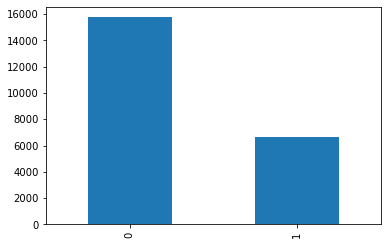

In [7]:
data["returnLabel"].value_counts().plot(kind="bar") #Zeigt Anzahl von nicht zurückgeschickt und zurückgeschickte Items

<h1>1.Laden Training Data </h1>

In [8]:
X_train = data.loc[:,"basket":"totalAmount"] #transactionId unnötig, basket, customerType, totalAmount - wichtige Features
y_train = data["returnLabel"] # Rückgabewert

<AxesSubplot:>

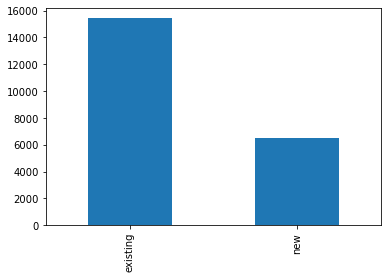

In [9]:
X_train["customerType"].value_counts().plot(kind="bar")


In [10]:
from pandas.plotting import scatter_matrix

<h1> Data preprocessing </h1>

In [11]:
from sklearn.impute import SimpleImputer

#### Behandeln fehlende numerische Werte

In [12]:
imputer = SimpleImputer(strategy="median") #behandeln fehlende Werte => strategy: durch median ersetzen 
totAm = X_train[["totalAmount"]] # nehme totalAmount Spalte
imputer.fit(totAm) # berechnet median 

SimpleImputer(strategy='median')

#### Behandeln fehlende kategorische Werte

In [13]:
mode = X_train["customerType"].mode().iloc[0] #gibt häufigste Wert zurück von kategorischen Features

In [14]:
def prepareData(my_data):
    
    
    my_data["AmountOfItems"] = my_data.basket.map(lambda x: len(str(x).strip("][").split(", ")))
    #basket
    list_ = []
    #Stellt eine Struktur dar, Liste von Dictionaries. Jede Dictionary(i) zeigt Häufigkeit von Produkten 0-5
    for i in my_data.index.values:    #range(my_data["basket"].shape[0])
        val = str(my_data.loc[i, "basket"]).strip("][").split(", ")
        list_.append(fromListToDic(val))
        
    #Erstellen Spalten 0 - 5 
    #Map erstellt Liste von Häufigkeiten abhängig von Waren
    for i in range(6): 
        my_data[str(i)] = list(map(lambda x: x[str(i)], list_))

    
    #Feature Engineering: if 5 was created 
    
    my_data["ifFifth"] = my_data["5"].map(lambda x: 0 if x >= 1 else 1)
    my_data["3or4not5"] = my_data["basket"].map(lambda x: 1 if(("3" in x or "4" in x) and "5" not in x) else 0)
    my_data["0or1or2"] = my_data["basket"].map(lambda x: 0 if(("0" in x or "1" in x or "2" in x) ) else 1)

    
    
    my_data = my_data.drop(columns=["basket"])

    return my_data

In [15]:

def one_hot_customer(my_data):
    one_hot_customer = pd.get_dummies(my_data["customerType"])
    my_data = pd.concat([my_data, one_hot_customer], axis=1)
    my_data = my_data.drop(columns=["customerType"])
    

    return my_data

In [16]:
md = {"name": "morteza", "alt" : 32, 2:"wtf"}
md["studium"] = "infb"
print(md.keys())
print(md["studium"])

dict_keys(['name', 'alt', 2, 'studium'])
infb


In [17]:
"""Zählt Werte in Liste listObj, sog Häufigkeit"""
def fromListToDic(listObj): #['4', '3', '4']
    my_dict = {}
    for i in range(len(listObj)): 
        if(listObj[i] not in my_dict.keys()):
            my_dict[listObj[i]] = 1
        else:
            my_dict[listObj[i]]+=1
            
    """Behandelt fehlende Keys in Liste. (weist 0 zu)"""
    for i in range(6):
        if(str(i) not in my_dict.keys()):
            my_dict[str(i)] = 0
    

    return my_dict

### Kleinere Beispiele von Hilfsmethoden

In [18]:
fromListToDic(X_train.loc[0,"basket"].strip('][').split(', '))
#X_train.loc[0,"basket"].strip('][').split(', ')

{'4': 2, '3': 1, '0': 0, '1': 0, '2': 0, '5': 0}

In [19]:
X_train.loc[0, "basket"].strip("[]")

'4, 3, 4'

In [20]:
X_train.loc[0, "basket"].strip("[]").split(", ")

['4', '3', '4']

##  3. Füllen Sie fehlende Werte in den Trainingsdaten auf 

In [21]:
X_train[["totalAmount"]] = imputer.transform(X_train[["totalAmount"]]) # jetzt werden fehlende Werte durch median erstzt
X_train[["customerType"]] = X_train[["customerType"]].fillna(mode) #NaN in customerType durch Häufigste Werte ersetzt 
#X_train[["customerType"]].fillna(mode, inplace=True) 

## 4. Transformieren Sie die kategorischen Features mittels One-hot-encoding.
## 5. Versuchen Sie auf Basis des Attributs basket Features zu bauen (z.B. wie oft kommt jede Kategorie im Basket vor).

In [22]:
X_train = prepareData(X_train)
X_train = one_hot_customer(X_train)

<h1>Exploratory Data Analysis </h1>

## 2. Führen Sie eine kurze EDA durch 

In [23]:
data.head()

,transactionId,basket,customerType,totalAmount,returnLabel
0,9534310106,"[4, 3, 4]",new,252.0,1
1,7202594767,"[4, 2, 0, 2, 5]",existing,70.0,0
2,2737331698,[5],existing,84.0,0
3,4868011733,"[1, 4, 2, 4]",existing,116.0,0
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",existing,378.0,0


In [24]:
X_train.head(10)

,totalAmount,AmountOfItems,0,1,2,3,4,5,ifFifth,3or4not5,0or1or2,existing,new
0,252.0,3,0,0,0,1,2,0,1,1,1,0,1
1,70.0,5,1,0,2,0,1,1,0,0,0,1,0
2,84.0,1,0,0,0,0,0,1,0,0,1,1,0
3,116.0,4,0,1,1,0,2,0,1,1,0,1,0
4,378.0,7,1,0,3,2,0,1,0,0,0,1,0
5,80.0,4,0,1,0,2,1,0,1,1,0,1,0
6,60.0,6,3,1,0,0,1,1,0,0,0,1,0
7,616.0,7,0,0,2,0,5,0,1,1,0,1,0
8,100.0,10,2,2,1,0,5,0,1,1,0,1,0
9,376.0,8,1,2,2,2,1,0,1,1,0,0,1


<AxesSubplot:ylabel='Frequency'>

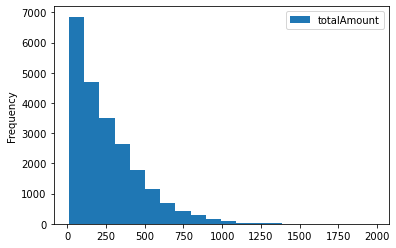

In [25]:
X_train[["totalAmount"]].plot(kind="hist", bins=20) #Y = Häufigkeit, X = Intervalle aller Geld  

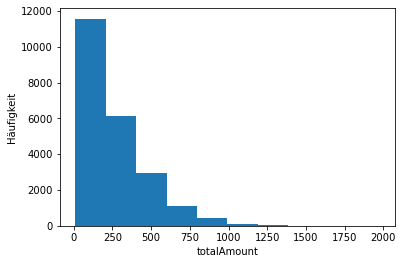

In [26]:
plt.hist(X_train["totalAmount"])
plt.xlabel("totalAmount")
plt.ylabel("Häufigkeit")
plt.show()

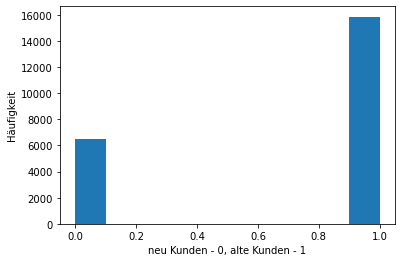

In [27]:
plt.hist(X_train["existing"])
plt.xlabel("neu Kunden - 0, alte Kunden - 1")
plt.ylabel("Häufigkeit")
plt.show()

In [28]:
some_data=pd.concat([X_train, y_train], axis=1) 


### Ermitteln sie die Verteilung von returnLabel i) über alle Daten ???

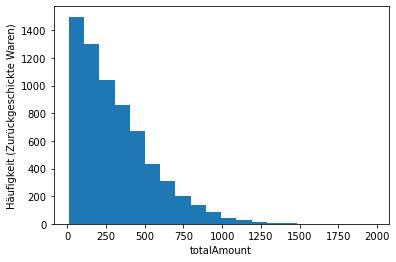

In [29]:
plt.hist(some_data[some_data["returnLabel"] == 1]["totalAmount"], bins=20)
plt.xlabel("totalAmount")
plt.ylabel("Häufigkeit (Zurückgeschickte Waren)")
plt.show()

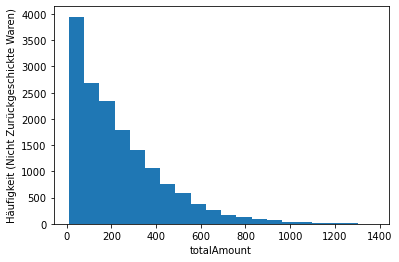

In [30]:
plt.hist(some_data[some_data["returnLabel"] == 0]["totalAmount"], bins=20)
plt.xlabel("totalAmount")
plt.ylabel("Häufigkeit (Nicht Zurückgeschickte Waren)")
plt.show()

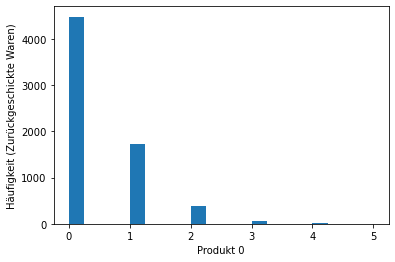

In [31]:
plt.hist(some_data[some_data["returnLabel"] == 1]["0"], bins=20)
plt.xlabel("Produkt 0") # >4000 - Anzahl von Basket, in dem kein Produkt 0 gibt, die zurückgeschickt wurden
plt.ylabel("Häufigkeit (Zurückgeschickte Waren)")
plt.show()

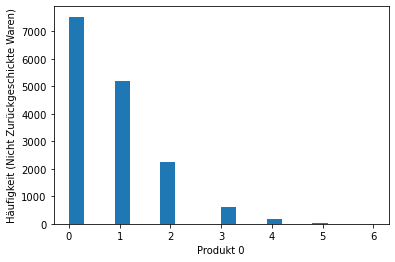

In [32]:
plt.hist(some_data[some_data["returnLabel"] == 0]["0"], bins=20)
plt.xlabel("Produkt 0") # >7000 - Anzahl von Basket, in dem kein Produkt 0 gibt, die nicht zurückgeschickt wurden
plt.ylabel("Häufigkeit (Nicht Zurückgeschickte Waren)")
plt.show()

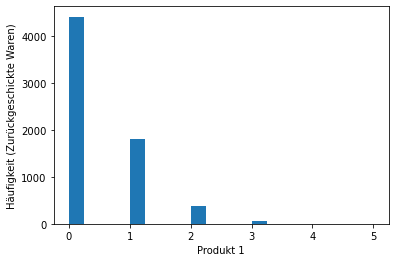

In [33]:
plt.hist(some_data[some_data["returnLabel"] == 1]["1"], bins=20)
plt.xlabel("Produkt 1") # >4000 - Anzahl von Basket, in dem kein Produkt 1 gibt, die zurückgeschickt wurden
plt.ylabel("Häufigkeit (Zurückgeschickte Waren)")
plt.show()

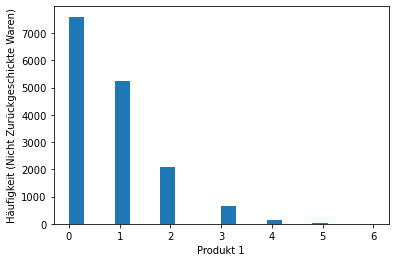

In [34]:
plt.hist(some_data[some_data["returnLabel"] == 0]["1"], bins=20)
plt.xlabel("Produkt 1") # >7000 - Anzahl von Basket, in dem kein Produkt 1 gibt, die nicht zurückgeschickt wurden
plt.ylabel("Häufigkeit (Nicht Zurückgeschickte Waren)")
plt.show()

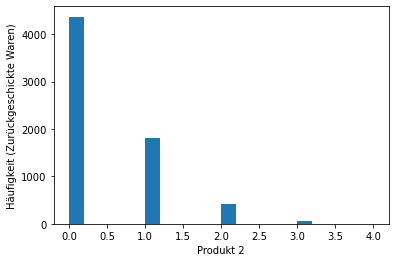

In [35]:
plt.hist(some_data[some_data["returnLabel"] == 1]["2"], bins=20)
plt.xlabel("Produkt 2") # >4000 - Anzahl von Basket, in dem kein Produkt 2 gibt, die zurückgeschickt wurden
plt.ylabel("Häufigkeit (Zurückgeschickte Waren)")
plt.show()

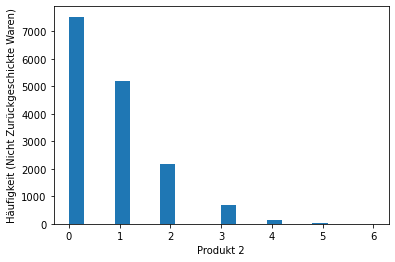

In [36]:
plt.hist(some_data[some_data["returnLabel"] == 0]["2"], bins=20)
plt.xlabel("Produkt 2") # >4000 - Anzahl von Basket, in dem kein Produkt 1 gibt, die nicht zurückgeschickt wurden
plt.ylabel("Häufigkeit (Nicht Zurückgeschickte Waren)")
plt.show()

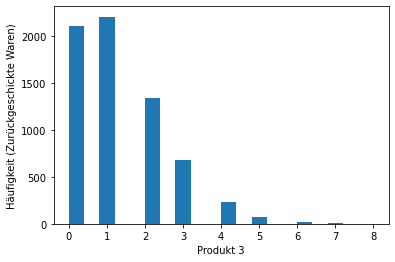

In [37]:
plt.hist(some_data[some_data["returnLabel"] == 1]["3"], bins=20)
plt.xlabel("Produkt 3") # >2000 - Anzahl von Basket, in dem kein Produkt 3 gibt, die zurückgeschickt wurden
plt.ylabel("Häufigkeit (Zurückgeschickte Waren)")
plt.show()

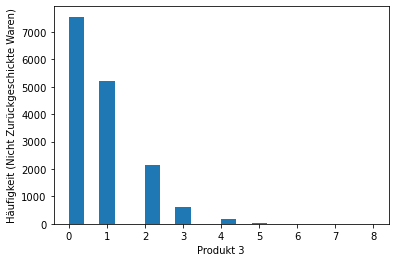

In [38]:
plt.hist(some_data[some_data["returnLabel"] == 0]["3"], bins=20)
plt.xlabel("Produkt 3") # >4000 - Anzahl von Basket, in dem kein Produkt 3 gibt, die nict zurückgeschickt wurden
plt.ylabel("Häufigkeit (Nicht Zurückgeschickte Waren)")
plt.show()

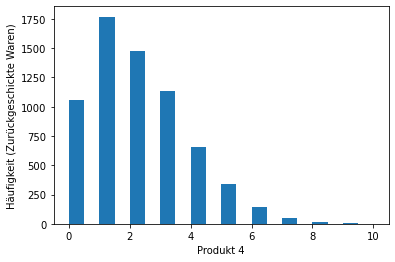

In [39]:
plt.hist(some_data[some_data["returnLabel"] == 1]["4"], bins=20)
plt.xlabel("Produkt 4") 
plt.ylabel("Häufigkeit (Zurückgeschickte Waren)")
plt.show()

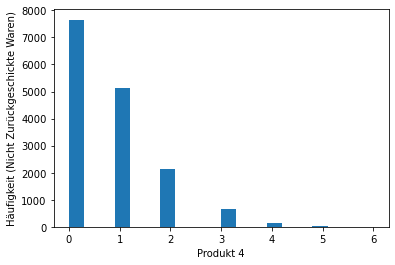

In [40]:
plt.hist(some_data[some_data["returnLabel"] == 0]["4"], bins=20)
plt.xlabel("Produkt 4") 
plt.ylabel("Häufigkeit (Nicht Zurückgeschickte Waren)")
plt.show()

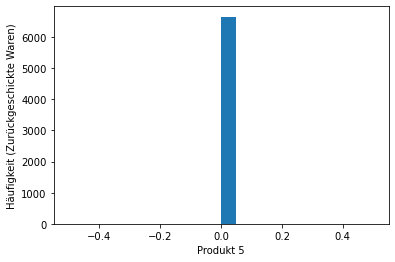

In [41]:
plt.hist(some_data[some_data["returnLabel"] == 1]["5"], bins=20)
plt.xlabel("Produkt 5") 
plt.ylabel("Häufigkeit (Zurückgeschickte Waren)")
plt.show()

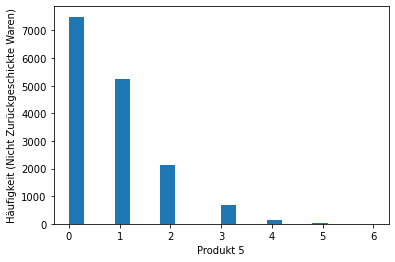

In [42]:
plt.hist(some_data[some_data["returnLabel"] == 0]["5"], bins=20)
plt.xlabel("Produkt 5") 
plt.ylabel("Häufigkeit (Nicht Zurückgeschickte Waren)")
plt.show()

### Ermitteln sie die Verteilung von returnLabel ii) in Abhängigkeit
### zu allen Ausprägungen von customerType

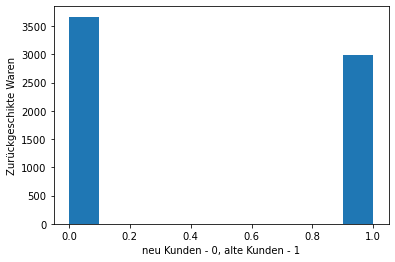

In [43]:
plt.hist(some_data[some_data["returnLabel"] == 1]["existing"])
plt.ylabel("Zurückgeschikte Waren")
plt.xlabel("neu Kunden - 0, alte Kunden - 1")
plt.show()

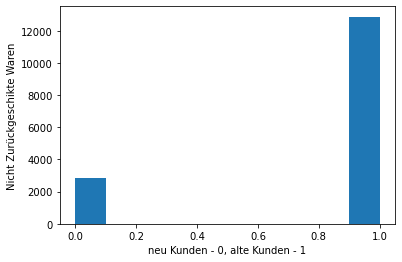

In [44]:
plt.hist(some_data[some_data["returnLabel"] == 0]["existing"])
plt.ylabel("Nicht Zurückgeschikte Waren")
plt.xlabel("neu Kunden - 0, alte Kunden - 1")
plt.show()

In [45]:
pd.concat([X_train["5"], y_train], axis=1).groupby(by="returnLabel").sum()

,5
returnLabel,
0,12319
1,0


In [46]:
dataex = pd.concat([X_train["existing"], y_train],axis=1)
dataex[dataex["returnLabel"] == 1].groupby(by="existing").count()

,returnLabel
existing,
0,3665
1,2987


In [47]:
datanew = pd.concat([X_train["new"], y_train],axis=1)
datanew[datanew["returnLabel"] == 1].groupby(by="new").count()

,returnLabel
new,
0,2987
1,3665


In [48]:
some_data.corr()

,totalAmount,AmountOfItems,0,1,2,3,4,5,ifFifth,3or4not5,0or1or2,existing,new,returnLabel
totalAmount,1.000000,0.684178,0.262564,0.260929,0.270573,0.404286,0.456082,0.156346,-0.093951,0.074644,-0.258612,-0.065320,0.065320,0.168470
AmountOfItems,0.684178,1.000000,0.454818,0.450762,0.446121,0.515178,0.507910,0.372937,-0.303313,-0.060252,-0.419399,0.008253,-0.008253,-0.011712
0,0.262564,0.454818,1.000000,0.119681,0.109747,0.036683,-0.012548,0.166020,-0.169834,-0.141414,-0.373360,0.079340,-0.079340,-0.195063
1,0.260929,0.450762,0.119681,1.000000,0.109225,0.049567,-0.014441,0.144141,-0.154102,-0.125316,-0.371509,0.080929,-0.080929,-0.187594
2,0.270573,0.446121,0.109747,0.109225,1.000000,0.042115,-0.012158,0.133674,-0.143338,-0.122766,-0.375045,0.069771,-0.069771,-0.186754
3,0.404286,0.515178,0.036683,0.049567,0.042115,1.000000,0.200261,-0.036485,0.059107,0.249255,-0.047479,-0.081459,0.081459,0.207076
4,0.456082,0.507910,-0.012548,-0.014441,-0.012158,0.200261,1.000000,-0.146244,0.184837,0.370513,0.002050,-0.171074,0.171074,0.456366
5,0.156346,0.372937,0.166020,0.144141,0.133674,-0.036485,-0.146244,1.000000,-0.843383,-0.673833,-0.134059,0.157064,-0.157064,-0.418620
ifFifth,-0.093951,-0.303313,-0.169834,-0.154102,-0.143338,0.059107,0.184837,-0.843383,1.000000,0.798964,0.123372,-0.182113,0.182113,0.496359
3or4not5,0.074644,-0.060252,-0.141414,-0.125316,-0.122766,0.249255,0.370513,-0.673833,0.798964,1.000000,0.224801,-0.205248,0.205248,0.553964


### Erstellen Sie einen Boxplot für totalAmount in Abhängigkeit des Labels (nutzen
### Sie dafür den Parameter by=…)

<AxesSubplot:title={'center':'totalAmount'}, xlabel='returnLabel'>

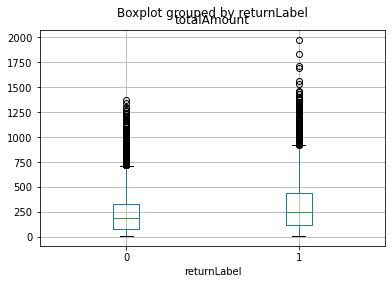

In [49]:
some_data.boxplot(column = "totalAmount", by="returnLabel", grid=True)


In [50]:
some_data[some_data["returnLabel"] == 0]["totalAmount"].describe()

count    15748.000000
mean       234.329947
std        197.766613
min         10.000000
25%         78.000000
50%        186.000000
75%        333.000000
max       1372.000000
Name: totalAmount, dtype: float64

In [51]:
some_data[some_data["returnLabel"] == 1]["totalAmount"].describe()

count    6652.000000
mean      313.644768
std       242.537213
min        10.000000
25%       120.000000
50%       252.000000
75%       440.000000
max      1976.000000
Name: totalAmount, dtype: float64

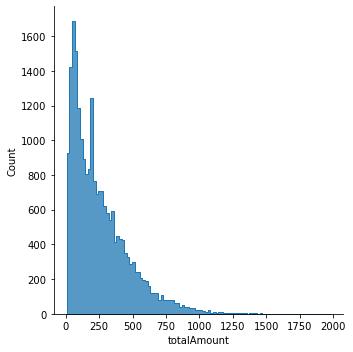

In [52]:
sns.displot(some_data, x="totalAmount", element="step")

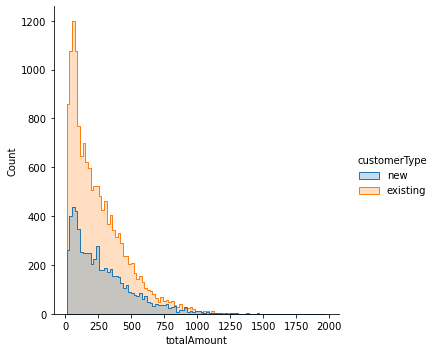

In [53]:
sns.displot(data, x="totalAmount", element="step", hue="customerType")

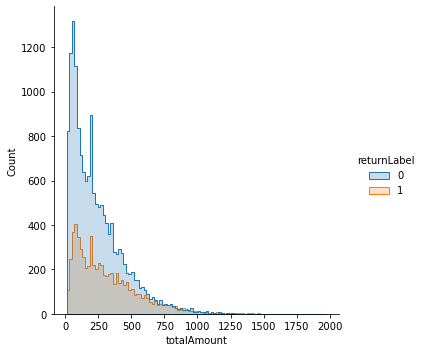

In [54]:
sns.displot(some_data, x="totalAmount", element="step", hue="returnLabel")

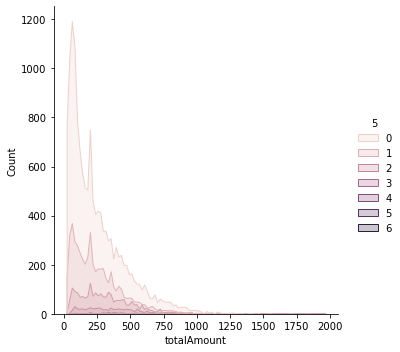

In [55]:
sns.displot(some_data, x="totalAmount", element="poly", hue="5") #elemets {step, poly, bars}

In [56]:
#some_data = pd.concat([X_train, y_train], axis=1)
#some_data[2 * some_data["4"] - some_data["AmountOfItems"] >= 0].groupby(by="returnLabel").sum()

In [57]:
pd.concat([X_train["4"], y_train], axis=1).groupby(by="returnLabel").sum()

,4
returnLabel,
0,12124
1,13898


In [58]:
pd.concat([X_train["3"], y_train], axis=1).groupby(by="returnLabel").sum()

,3
returnLabel,
0,12290
1,8347


In [59]:
pd.concat([X_train["2"], y_train], axis=1).groupby(by="returnLabel").sum()

,2
returnLabel,
0,12332
1,2834


In [60]:
pd.concat([X_train["1"], y_train], axis=1).groupby(by="returnLabel").sum()

,1
returnLabel,
0,12085
1,2749


In [61]:
pd.concat([X_train["0"], y_train], axis=1).groupby(by="returnLabel").sum()

,0
returnLabel,
0,12248
1,2715


<h1> Feature Scaling</h1>

## 6. Skalieren Sie die Features mit einem StandardScaler.

In [62]:
std_sc_all = StandardScaler().fit(X_train)
X_train_scaled = std_sc_all.transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index = X_train.index, columns=X_train.columns)

In [63]:
"""Skalieren Test Daten"""
def testScale(my_data):
    my_data_scaled = std_sc_all.transform(my_data)
    my_data = pd.DataFrame(my_data_scaled, index = my_data.index, columns=my_data.columns)
    return my_data

In [64]:
X_train.head() #Values can be more than 1 because max could be in test

,totalAmount,AmountOfItems,0,1,2,3,4,5,ifFifth,3or4not5,0or1or2,existing,new
0,-0.027351,-0.607275,-0.771563,-0.767737,-0.775046,0.075189,0.634586,-0.644106,0.763716,0.955883,2.066540,-1.558612,1.558612
1,-0.873409,0.133204,0.383487,-0.767737,1.514422,-0.880132,-0.122402,0.527090,-1.309387,-1.046153,-0.483901,0.641597,-0.641597
2,-0.808327,-1.347754,-0.771563,-0.767737,-0.775046,-0.880132,-0.879391,0.527090,-1.309387,-1.046153,2.066540,0.641597,-0.641597
3,-0.659570,-0.237036,-0.771563,0.391580,0.369688,-0.880132,0.634586,-0.644106,0.763716,0.955883,-0.483901,0.641597,-0.641597
4,0.558381,0.873682,0.383487,-0.767737,2.659156,1.030510,-0.879391,0.527090,-1.309387,-1.046153,-0.483901,0.641597,-0.641597


<h1> Training Models</h1>

## 7. Trainieren Sie die folgenden Klassifikationsmodelle und probieren Sie die angegebenen Hyperparameter mittels Cross-Validation aus:

In [65]:

from sklearn.linear_model import LogisticRegression,LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Logistische Regression

In [66]:
C = [0.1,1,4,5,6,10,30,100]
penalty = ["l1", "l2"]
log_models = []
#lbfgs
#liblinear
logReg = GridSearchCV(
        estimator = LogisticRegression(max_iter=1000, solver="liblinear", random_state=0),
        param_grid = {
            'C': C,
            "penalty": penalty,
        },
        n_jobs=-1,
        cv=5 #old version is 3
    )

### Trainieren Logistische Regression

In [67]:
logReg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, random_state=0,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 4, 5, 6, 10, 30, 100],
                         'penalty': ['l1', 'l2']})

## Random Forest und Gradient Boosting Tree

In [68]:
n_estimators = [60,80,100,120,140]
max_depth = [2, 4, 6]

parameter_candidates = [
                        {
                        'n_estimators': n_estimators,
                        "max_depth": max_depth,
                        }
                       ]
rf = RandomForestClassifier(random_state = 0)
gb = GradientBoostingClassifier(random_state = 0)
grid_rf = GridSearchCV(estimator=rf, param_grid=parameter_candidates, n_jobs=-1, cv= 5)
grid_gb = GridSearchCV(estimator=gb, param_grid=parameter_candidates, n_jobs=-1, cv = 5)


## Trainieren Random Forest und GBT

In [69]:
grid_rf.fit(X_train, y_train)
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid=[{'max_depth': [2, 4, 6],
                          'n_estimators': [60, 80, 100, 120, 140]}])

## 8. Laden Sie die Testdaten.

In [70]:
test_data = pd.read_csv("data/project/test.csv", delimiter=";")

In [71]:
test_data.info()
test_data.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  9600 non-null   int64  
 1   basket         9600 non-null   object 
 2   customerType   9397 non-null   object 
 3   totalAmount    9425 non-null   float64
 4   returnLabel    9600 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 375.1+ KB


,transactionId,basket,customerType,totalAmount,returnLabel
0,4132523932,"[4, 3, 4, 3, 2, 3]",existing,366.0,1
1,8998574539,"[3, 4, 4, 3, 5]",existing,85.0,0
2,9346688547,"[1, 1, 2, 2, 4, 4, 3, 1, 1, 0, 3]",existing,275.0,0
3,4533897707,"[3, 2, 2, 1, 5, 1, 1, 0]",existing,528.0,0
4,3334800500,"[4, 2, 3, 5, 2, 5, 1]",existing,287.0,0
5,4959057525,"[4, 4, 3]",existing,NaN,1


## 9. Entfernen Sie alle Zeilen mit fehlenden Werten.

In [72]:
X_test = test_data.loc[:,["basket","totalAmount", "customerType"]]
#X_test = X_test[test_data["customerType"].notna()]  
#X_test = X_test[test_data["totalAmount"].notna()] 
X_test = X_test.dropna()

In [73]:
print(X_test["totalAmount"].isna().sum()) #Prüfen, ob fehlende Werte existieren 
print(X_test["customerType"].isna().sum()) #Prüfen, ob fehlende Werte existieren 

0
0


In [74]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9226 entries, 0 to 9599
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   basket        9226 non-null   object 
 1   totalAmount   9226 non-null   float64
 2   customerType  9226 non-null   object 
dtypes: float64(1), object(2)
memory usage: 288.3+ KB


## 10. Transformieren Sie die Attribute genauso wie bei den Trainingsdaten.

In [75]:
X_test = prepareData(X_test) #Basket Column umgewandelt und ein paar Spalte hinzufügt 
y_test = test_data.loc[X_test.index, "returnLabel"]
X_test = one_hot_customer(X_test) # One Hot Encoding customerType

In [76]:
y_test #Series

0       1
1       0
2       0
3       0
4       0
       ..
9595    0
9596    0
9597    1
9598    0
9599    0
Name: returnLabel, Length: 9226, dtype: int64

In [77]:
y_test = pd.DataFrame(y_test) 

In [78]:
y_test #Pandas

,returnLabel
0,1
1,0
2,0
3,0
4,0
...,...
9595,0
9596,0
9597,1
9598,0


In [79]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9226 entries, 0 to 9599
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   returnLabel  9226 non-null   int64
dtypes: int64(1)
memory usage: 402.2 KB


In [80]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9226 entries, 0 to 9599
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   totalAmount    9226 non-null   float64
 1   AmountOfItems  9226 non-null   int64  
 2   0              9226 non-null   int64  
 3   1              9226 non-null   int64  
 4   2              9226 non-null   int64  
 5   3              9226 non-null   int64  
 6   4              9226 non-null   int64  
 7   5              9226 non-null   int64  
 8   ifFifth        9226 non-null   int64  
 9   3or4not5       9226 non-null   int64  
 10  0or1or2        9226 non-null   int64  
 11  existing       9226 non-null   uint8  
 12  new            9226 non-null   uint8  
dtypes: float64(1), int64(10), uint8(2)
memory usage: 1.1 MB


## 11. Skalieren Sie die Daten im gleichem Maß wie die Trainingsdaten.

In [81]:
X_test = testScale(X_test)

In [82]:
X_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9226 entries, 0 to 9599
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   totalAmount    9226 non-null   float64
 1   AmountOfItems  9226 non-null   float64
 2   0              9226 non-null   float64
 3   1              9226 non-null   float64
 4   2              9226 non-null   float64
 5   3              9226 non-null   float64
 6   4              9226 non-null   float64
 7   5              9226 non-null   float64
 8   ifFifth        9226 non-null   float64
 9   3or4not5       9226 non-null   float64
 10  0or1or2        9226 non-null   float64
 11  existing       9226 non-null   float64
 12  new            9226 non-null   float64
dtypes: float64(13)
memory usage: 1.2 MB


## 12. Machen Sie eine Vorhersage auf den Testdaten mit allen drei Modellen und den jeweils besten Hyperparametern aus der Cross Validation.

In [83]:
predictions_logreg = logReg.predict(X_test)
predictions_rf = grid_rf.predict(X_test)
predictions_gb = grid_gb.predict(X_test)


In [84]:
logReg.best_params_

{'C': 1, 'penalty': 'l2'}

In [85]:
grid_rf.best_params_

{'max_depth': 6, 'n_estimators': 100}

In [86]:
grid_gb.best_params_

{'max_depth': 4, 'n_estimators': 120}

## 13. Berechnen Sie für jedes der drei Modell Accuracy, Precision und Recall

In [87]:
from sklearn.metrics import precision_score, mean_squared_error, recall_score, accuracy_score, f1_score

In [88]:
#Gradient Boosting Tree scores
print("accuracy: ", accuracy_score(y_test, grid_gb.predict(X_test)))
print("precision: ", precision_score(y_test, grid_gb.predict(X_test)))
print("recall: ", recall_score(y_test, grid_gb.predict(X_test)))
print("f1 score: ", f1_score(y_test, grid_gb.predict(X_test)))

accuracy:  0.8749187079991328
precision:  0.8028009084027252
recall:  0.7701525054466231
f1 score:  0.7861378799110453


In [89]:
#Random Forest
print("accuracy: ", accuracy_score(y_test, grid_rf.predict(X_test)))
print("precision: ", precision_score(y_test, grid_rf.predict(X_test)))
print("recall: ", recall_score(y_test, grid_rf.predict(X_test)))
print("f1 score: ", f1_score(y_test, grid_rf.predict(X_test)))

accuracy:  0.8599609798395838
precision:  0.7882492113564669
recall:  0.7258533042846769
f1 score:  0.7557655954631379


In [90]:
#Logistic Regression
print("accuracy: ", accuracy_score(y_test, logReg.predict(X_test)))
print("precision: ", precision_score(y_test, logReg.predict(X_test)))
print("recall: ", recall_score(y_test, logReg.predict(X_test)))
print("f1 score: ", f1_score(y_test, logReg.predict(X_test)))

accuracy:  0.8729676999783221
precision:  0.8131433095803642
recall:  0.7458242556281772
f1 score:  0.7780303030303031


## 14. Berechnen Sie außerdem die Accuracy auf den Trainingsdaten und vergleichen Sie Accuracy auf Trainings- und Testdaten. Liegt Overfitting vor? 

In [91]:
print("Logistic Regression: " , accuracy_score(y_train, logReg.predict(X_train)))
print("Random Forest: ", accuracy_score(y_train, grid_rf.predict(X_train)))
print("Gradient Boosting Tree: ", accuracy_score(y_train, grid_gb.predict(X_train)))


Logistic Regression:  0.8790178571428572
Random Forest:  0.8709821428571428
Gradient Boosting Tree:  0.8861160714285714


## 15. Untersuchen Sie wieviele Datenpunkte es in den Testdaten gibt, welche von allen drei Modellen falsch klassifiziert wurden

In [92]:
print((y_train == 0).sum() / y_train.shape) #Funny 


[0.70303571]


In [93]:
df_pred_lg = pd.DataFrame(predictions_logreg) # Predictions in DataFrame umgewandelt 
df_pred_rf = pd.DataFrame(predictions_rf)
df_pred_gb = pd.DataFrame(predictions_gb)

In [94]:
y_test.shape

(9226, 1)

In [95]:
y_test.to_numpy()

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [96]:
y_test_np = np.resize(y_test.to_numpy(), y_test.shape[0]) #eine richtige Grösse angepasst
y_test_np

array([1, 0, 0, ..., 1, 0, 0])

## Untersuchen Sie wieviele Datenpunkte es in den Testdaten gibt, welche von allen drei Modellen falsch klassifiziert wurden:

### 1. Bestimmen Sie für jedes der drei Modelle die Indizes der Testdatenpunkte auf welchen das jeweilige Modell falsch klassifiziert hat.

In [97]:
false_index_lg = y_test[(y_test_np != predictions_logreg) ].index
false_index_rf = y_test[(y_test_np != predictions_rf) ].index
false_index_gb = y_test[(y_test_np != predictions_gb)].index


In [98]:
intersection = set(false_index_lg) &  set(false_index_rf) & set(false_index_gb)

### 2. Untersuchen Sie wieviele Datenpunkte es in den Testdaten gibt, welche von allen drei Modellen falsch klassifiziert wurden:

In [102]:
len(intersection)

883